<a href="https://colab.research.google.com/github/astroC86/BERT_AI_Project/blob/main/AIProject4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
# Link for how to download kaggle data to colab
import os.path
from google.colab import files


if not os.path.isfile("/root/.kaggle/kaggle.json"):
  t = files.upload()
  t = None

Saving kaggle.json to kaggle (1).json


In [4]:
!pwd

/content


In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip -o imdb-dataset-of-50k-movie-reviews.zip  #unzip data 

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [8]:
from sklearn.model_selection import train_test_split
import pandas            as pd

First 10 rows of the DataFrame:


<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

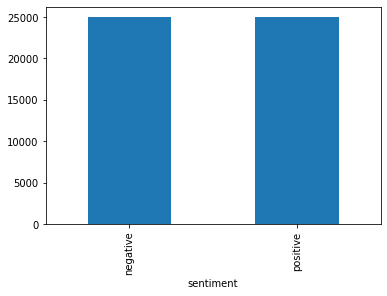

In [9]:
df        = pd.read_csv("IMDB Dataset.csv")
print("First 10 rows of the DataFrame:")
#print(df)

df.groupby(['sentiment']).size().plot.bar()
df.describe

In [10]:
x_org = df.drop(["sentiment"], axis="columns")
y_org = df.drop(["review"], axis="columns").replace({"positive": 1, "negative": 0})

print('review')
print(x_org)

print('sentiment')
print(y_org)

print("Original training dataset shape:")
print(y_org.squeeze().value_counts())

print("\n\n data is split equaly from the get go")

review
                                                  review
0      One of the other reviewers has mentioned that ...
1      A wonderful little production. <br /><br />The...
2      I thought this was a wonderful way to spend ti...
3      Basically there's a family where a little boy ...
4      Petter Mattei's "Love in the Time of Money" is...
...                                                  ...
49995  I thought this movie did a down right good job...
49996  Bad plot, bad dialogue, bad acting, idiotic di...
49997  I am a Catholic taught in parochial elementary...
49998  I'm going to have to disagree with the previou...
49999  No one expects the Star Trek movies to be high...

[50000 rows x 1 columns]
sentiment
       sentiment
0              1
1              1
2              1
3              0
4              1
...          ...
49995          1
49996          0
49997          0
49998          0
49999          0

[50000 rows x 1 columns]
Original training dataset shape:
1    25000

In [11]:
x_train, x_testValidate, y_train, y_testValidate = train_test_split(x_org, y_org,
                                                    test_size    = 0.30,
                                                    random_state = 0,
                                                    stratify     = y_org)


x_validate, x_test, y_validate, y_test          = train_test_split(x_testValidate, y_testValidate,
                                                    test_size=(2/3),
                                                    random_state=0,
                                                    stratify=y_testValidate)

print("Positive-Negative split for training")
print(y_train.squeeze().value_counts())

print("\n\nPositive-Negative split for testing")
print(y_test.squeeze().value_counts())

print("\n\nPositive-Negative split for validation")
print(y_validate.squeeze().value_counts())


Positive-Negative split for training
1    17500
0    17500
Name: sentiment, dtype: int64


Positive-Negative split for testing
0    5000
1    5000
Name: sentiment, dtype: int64


Positive-Negative split for validation
1    2500
0    2500
Name: sentiment, dtype: int64


In [12]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from typing_extensions import final
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocess(text):
  texts = re.sub(CLEANR, ' ', text) # reomving html entities
  texts = "".join([char for char in texts if char not in string.punctuation]) # removing punctiuation
  texts = texts.lower() #lowering 
  texts = texts.split(' ')
  texts = [word for word in texts if word not in stop_words] #removing stopwords
  texts = [lemmatizer.lemmatize(word=word,pos='v') for word in texts] #lematizing
  texts = ' '.join(texts)
  return texts

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
pp_x_train            = x_train.copy()
pp_x_train['review']  = x_train['review'].apply(preprocess)

pp_y_train    = y_train


pp_x_validate           = x_validate.copy()
pp_x_validate['review'] = x_validate['review'].apply(preprocess)

pp_x_test           = x_test.copy()
pp_x_test['review'] = x_test['review'].apply(preprocess)

pp_y_validate, pp_y_test = y_validate, y_test


In [14]:
!pip install transformers livelossplot

In [15]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, _x,_y):
      self.texts     = _x
      self.sentiment = _y
      self.sentiment = torch.FloatTensor(_y)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        global tokenizer
        batch_texts = tokenizer(self.texts[idx][0], 
                                padding          = 'max_length', 
                                max_length       = 512, 
                                truncation       = True,
                                return_tensors   = "pt")
        
        batch_y     = self.sentiment[idx][0]
        return batch_texts, batch_y

### **Preparing BERT Model**

In [28]:
EPOCHS         = 15 
BATCH_SIZE     = 128
LEARNING_RATE  = 0.0001

In [31]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.bert    = BertModel.from_pretrained('bert-base-cased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.l1      = nn.Linear(768, 512)
        self.l2      = nn.Linear(512, 256)
        self.l3      = nn.Linear(256, 64)
        self.l4      = nn.Linear(64 , 1)

        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(64)

        self.relu    = nn.ReLU()
        
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        x                = self.dropout (pooled_output)
        
        x                = self.batchnorm1(self.l1(x))
        x                = self.dropout (self.relu(x))
        x                = self.batchnorm2(self.l2(x))
        x                = self.dropout (self.relu(x))
        x                = self.batchnorm3(self.l3(x))
        x                = self.dropout (self.relu(x))
        x                = torch.sigmoid(self.l4(x))
        return x

In [18]:
g_tloss = []
g_vloss = []

g_tacc = []
g_vacc = []

In [19]:
from tqdm import tqdm
import gc
from livelossplot import PlotLosses



def train(model, x_train_data, Y_train_data, x_val_data,Y_val_data, learning_rate, epochs):
    global g_tloss, g_vloss,g_tacc,g_vacc
    train = MyDataset(x_train_data.values,Y_train_data.values)
    val   = MyDataset(x_val_data.values,Y_val_data.values)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader   = torch.utils.data.DataLoader(val, batch_size=BATCH_SIZE)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device('cpu')
    model.to(device)

    liveloss_train = PlotLosses()
    liveloss_val   = PlotLosses()

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    iters = len(train_dataloader)
    for epoch_num in range(epochs):
            total_acc_train  = 0
            total_loss_train = 0
            t_logs = {}
            v_logs={}
            model.train()
            batch_ndx = 0
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                
                mask        = train_input['attention_mask'].to(device)
                input_id    = train_input['input_ids'].squeeze(1).to(device)

                output     = model(input_id, mask)

                batch_loss = criterion(output, train_label.unsqueeze(1))
                #print(output, train_label.unsqueeze(1))
                total_loss_train += batch_loss.item()
                output      = (output >0.5).float()
                train_label = train_label.unsqueeze(1)
                acc         = (output == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                t_logs['train_log loss'] = batch_loss.item()/BATCH_SIZE
                t_logs['train_accuracy'] = acc/BATCH_SIZE
                g_tloss.append(t_logs['train_log loss'])
                g_tacc.append(t_logs['train_accuracy'])
                
                liveloss_train.update(t_logs)
                liveloss_train.send()
                
                del train_input
                del train_label
                batch_ndx += 1
                gc.collect()

            total_acc_val  = 0
            total_loss_val = 0
            model.eval()
            Flag = False
            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    val_label = val_label.to(device)
                    mask      = val_input['attention_mask'].to(device)
                    input_id  = val_input['input_ids'].squeeze(1).to(device)

                    output          = model(input_id, mask)
                    batch_loss      = criterion(output, val_label.unsqueeze(1))
                    total_loss_val += batch_loss.item()
                    
                    output         = (output >0.5).float()
                    val_label      = val_label.unsqueeze(1)
                    acc            = (output == val_label).sum().item()
                    total_acc_val += acc

                    v_logs['val_log loss'] = batch_loss.item()/BATCH_SIZE
                    v_logs['val_accuracy'] = acc/BATCH_SIZE
                    
                    g_vloss.append(v_logs['val_log loss'])
                    g_vacc.append(v_logs['val_accuracy'])
                    
                    liveloss_val.update(v_logs)
                    liveloss_val.send()

                    del val_input
                    del val_label
                    gc.collect()
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(x_train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(x_train_data): .3f} \
                | Val Loss: {total_loss_val / len(x_val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(x_val_data): .3f}')

In [32]:
model     = BertClassifier()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
#print(list(model.parameters())[-3])
#print(model.l3.weight)
#print(list(model.l1.parameters())[1].shape)

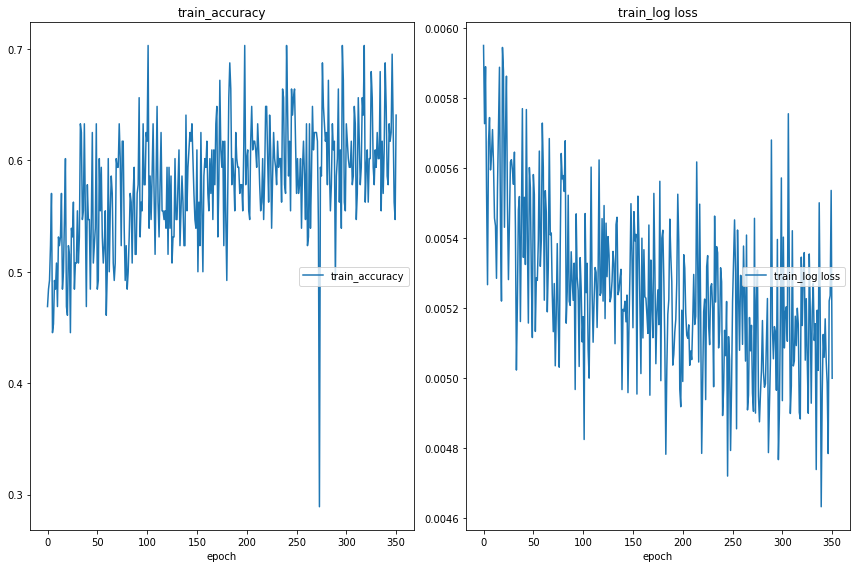

 28%|██▊       | 77/274 [12:25<31:54,  9.72s/it]

train_accuracy
	train_accuracy   	 (min:    0.289, max:    0.703, cur:    0.641)
train_log loss
	train_log loss   	 (min:    0.005, max:    0.006, cur:    0.005)


In [ ]:
for i in range(0,100):
    gc.collect()
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()

train(model,pp_x_train,pp_y_train,pp_x_validate,pp_y_validate,LEARNING_RATE,EPOCHS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

plt.plot(g_vacc , color="red")
plt.show()

In [ ]:
import pickle

with open('not_pp_g_vacc','wb') as f: 
    pickle.dump( np.array(g_vacc), f)

with open('not_pp_g_vloss','wb') as f: 
    pickle.dump( np.array(g_vloss), f)

with open('not_pp_g_tacc','wb') as f: 
    pickle.dump( np.array(g_tacc), f)

with open('not_pp_g_tloss','wb') as f: 
    pickle.dump( np.array(g_tloss), f)

In [ ]:
torch.save(model, "checkpoint_no_pp_1.t7")

In [ ]:
def evaluate(model, x_test,Y_test):
    test = MyDataset(x_test.values,Y_test.values)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    curr_b         = 0
    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader):
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              output         = (output > 0.5).float()
              test_label     = test_label.unsqueeze(1)
              acc            = (output == test_label).sum().item()
              #print((output == test_label))
              total_acc_test += acc
              curr_b+=1
              print(f'Total Acc: {total_acc_test/(curr_b*BATCH_SIZE):.3f}')

    print(f'Test Accuracy: {total_acc_test / len(x_test): .3f}')

In [ ]:
model = torch.load("checkpoint_no_pp_1.t7")

In [ ]:
#print(model)
for i in range(0,100):
    gc.collect()
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.empty_cache()
evaluate(model, pp_x_test,pp_y_test)